In [ ]:
python -m spacy download en_core_web_sm

In [112]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
import numpy as np
from scipy.stats import randint
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()


df = pd.read_csv('stock_data.csv')
df['Text'] = df['Text'].astype(str)
df['Date'] = pd.to_datetime(df['Date'])
df['Sentiment'] = df['Sentiment'].astype(np.int64)
print(df.info())

test_data = pd.read_csv('s1.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'])
# test_data= test_data.iloc[:,:-1]
# test_data.rename(columns = {'Title':'Text'}, inplace = True)
test_data['Text'] = test_data['Text'].astype(str)
# test_data =test_data.replace(r'^\s*$', np.nan, regex=True)
# test_data = test_data[['Text','Date']].merge(df, on=['Text','Date'], how='left')
# test_data = test_data[test_data['Text'].str.contains("\?")==False]
print(test_data.info())
print(df['Sentiment'].value_counts())

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

to_remove = ['up', 'down','low','high','below','less','fall']
new_stopwords = set(stopwords.words('english')).difference(to_remove)
stemmer = SnowballStemmer(language='english')
def text_data_cleaning(sentence):
    sent = preprocess_text(sentence)
    doc = nltk.word_tokenize(sent)
    lemma =[lemmatizer.lemmatize(word, pos ="v") for word in doc]
    return append_message(lemma)
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    sentence = sen.lower()
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub('rs|cr|crore|point|points|pt|stock', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) 
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(new_stopwords) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

def append_message(text):
  str = " "
  return (str.join(text))

df['Tok_text'] = df['Text'].apply(text_data_cleaning)
df['Tok_text'] = df['Tok_text'].astype(str)
tf_idf_vect = TfidfVectorizer()

df2 = df.iloc[:,2:]

df_train, df_test = train_test_split(df2, test_size=0.3, random_state=42,
                                     stratify=df2['Sentiment'])
X_train = tf_idf_vect.fit_transform(df_train['Tok_text'])
y_train = df_train['Sentiment']
X_test = tf_idf_vect.transform(df_test['Tok_text'])
y_test = df_test['Sentiment']

test_data['Tok_text'] = test_data['Text'].apply(text_data_cleaning)
x_test = tf_idf_vect.transform(test_data['Tok_text'])
print(x_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47066 entries, 0 to 47065
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       47066 non-null  object        
 1   Date       47066 non-null  datetime64[ns]
 2   Sentiment  47066 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1530 non-null   int64         
 1   Text        1530 non-null   object        
 2   Date        1530 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 36.0+ KB
None
1    23412
0    13389
2    10265
Name: Sentiment, dtype: int64
(1530, 10436)


In [15]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

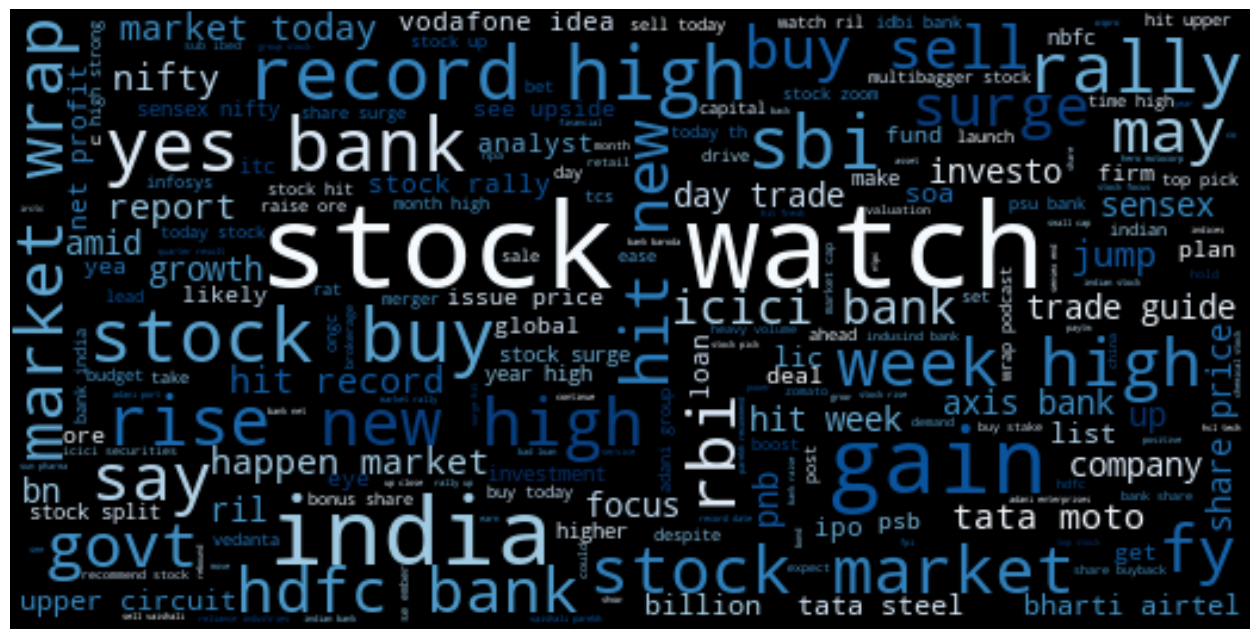

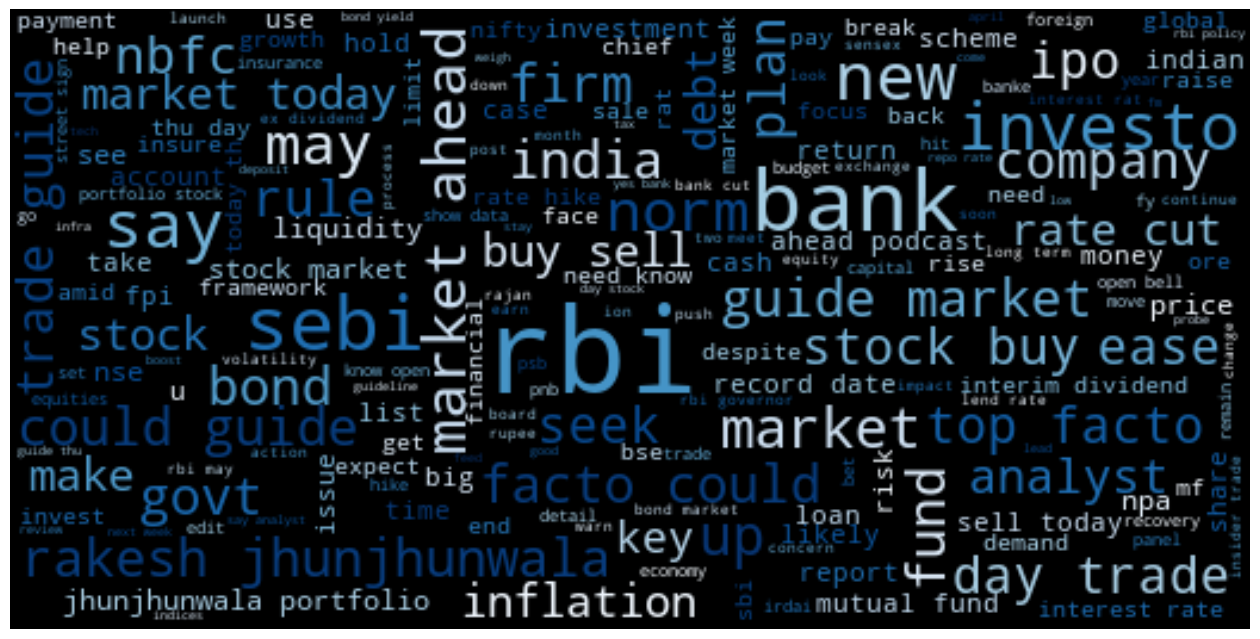

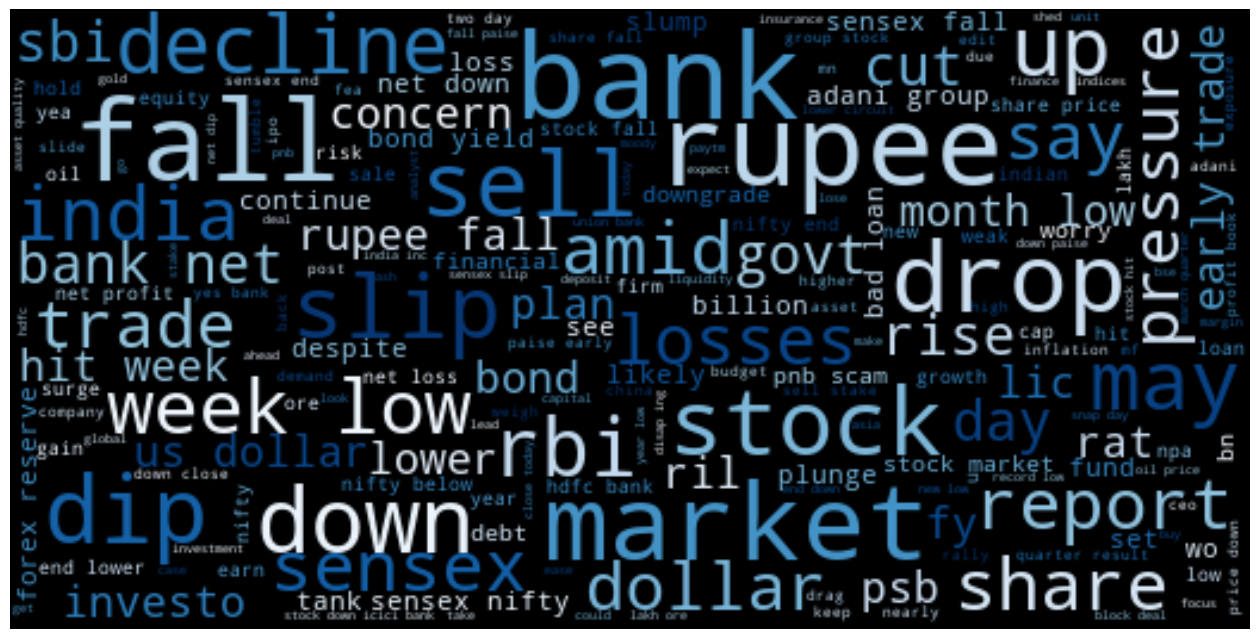

In [103]:
pos_msg = df[df['Sentiment'] == 1]
zeo_msg = df[df['Sentiment']==0]
nrg_msg = df[df['Sentiment']==2]
pos_msg_text = " ".join(pos_msg.Tok_text.to_numpy().tolist())
zeo_msg_text = " ".join(zeo_msg.Tok_text.to_numpy().tolist())
nrg_msg_text = " ".join(nrg_msg.Tok_text.to_numpy().tolist())

pos_msg_cloud = WordCloud(width =520, height =260, stopwords=new_stopwords,max_font_size=50, background_color ="black", colormap='Blues').generate(pos_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(pos_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()
zeo_msg_cloud = WordCloud(width =520, height =260, stopwords=new_stopwords,max_font_size=50, background_color ="black", colormap='Blues').generate(zeo_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(zeo_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()
nrg_msg_cloud = WordCloud(width =520, height =260, stopwords=new_stopwords,max_font_size=50, background_color ="black", colormap='Blues').generate(nrg_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(nrg_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()


In [113]:
clf1 = SGDClassifier(alpha=0.0001,loss='modified_huber')
clf1.fit(X_train,y_train)
y_pred = clf1.predict(X_test)
print(classification_report(y_test, y_pred))
score = accuracy_score(y_pred,y_test)
print(score,"SDG")

clf2 = LogisticRegression(C=10,multi_class='multinomial',penalty='l2',solver='lbfgs')
clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)
print(classification_report(y_test,y_pred2))
score1 = accuracy_score(y_pred2,y_test)
print(score, "LR")

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4017
           1       0.89      0.93      0.91      7024
           2       0.89      0.83      0.86      3079

    accuracy                           0.89     14120
   macro avg       0.89      0.87      0.88     14120
weighted avg       0.89      0.89      0.89     14120

0.8863314447592068 SDG
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4017
           1       0.90      0.91      0.90      7024
           2       0.87      0.84      0.86      3079

    accuracy                           0.88     14120
   macro avg       0.88      0.87      0.87     14120
weighted avg       0.88      0.88      0.88     14120

0.8863314447592068 LR


c:\Users\kings\OneDrive\Documents\Dev\Stock-Analysis\envr\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
rf_model = RandomForestClassifier()

# define the hyperparameter search space
param_dist = {
    'n_estimators': randint(50, 250),
    'max_depth': [None] + list(randint(3, 20).rvs(size=5)),
    'max_features': randint(1, X_train.shape[1]),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'n_jobs':[-1]
}

# define the randomized search object with cross-validation
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)

# fit the randomized search object to the training data
random_search.fit(X_train, y_train)

# print the best hyperparameters
print("Best hyperparameters:", random_search.best_params_)
best_model = random_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))

c:\Users\kings\OneDrive\Documents\Dev\Stock-Analysis\envr\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       0.81      0.63      0.71      2062
           1       0.84      0.94      0.88      5929
           2       0.83      0.71      0.76      1807

    accuracy                           0.83      9798
   macro avg       0.83      0.76      0.79      9798
weighted avg       0.83      0.83      0.82      9798

0.8304756072667892 SDG


In [42]:
from sklearn.model_selection import GridSearchCV
lr_model = LogisticRegression()

# define the hyperparameter search space
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 500],
    'n_jobs':[-1],
    'multi_class':['multinomial','ovr']
}

# define the grid search object with cross-validation
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy')

# fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# get the best model
best_model = grid_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))

c:\Users\kings\OneDrive\Documents\Dev\Stock-Analysis\envr\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
c:\Users\kings\OneDrive\Documents\Dev\Stock-Analysis\envr\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
c:\Users\kings\OneDrive\Documents\Dev\Stock-Analysis\envr\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
c:\Users\kings\OneDrive\Documents\Dev\Stock-Analysis\envr\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
c:\Users\kings\OneDrive\Documents\Dev\Stock-

Best hyperparameters: {'C': 10, 'max_iter': 100, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      2062
           1       0.89      0.93      0.91      5929
           2       0.83      0.77      0.80      1807

    accuracy                           0.86      9798
   macro avg       0.84      0.82      0.83      9798
weighted avg       0.86      0.86      0.86      9798



In [ ]:
from sklearn.svm import SVC
svm_model = SVC(decision_function_shape='ovr')

# define the hyperparameter search space
param_grid = {
    'C': [0.001,0.01,0.1, 10],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

# define the grid search object with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# get the best model
best_model = grid_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()

# define the hyperparameter search space
param_grid = {
    'learning_rate': [0.05, 0.1, 0.25, 1.0],
    'n_estimators': [50, 100, 200, 250],
    'max_depth': [3, 4, 7],
    'min_samples_split': [2, 8],
    'min_samples_leaf': [1,6],
}

# define the grid search object with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# get the best model
best_model = grid_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
mlp_model = MLPClassifier()

# define the hyperparameter search space
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50), (100,100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 300],
}

# define the grid search object with cross-validation
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, scoring='accuracy')

# fit the grid search object to the training data
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

# get the best model
best_model = grid_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))

c:\Users\kings\OneDrive\Documents\Dev\Stock-Analysis\envr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kings\OneDrive\Documents\Dev\Stock-Analysis\envr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kings\OneDrive\Documents\Dev\Stock-Analysis\envr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kings\OneDrive\Documents\Dev\Stock-Analysis\envr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached 

In [ ]:
sgd_model = SGDClassifier(loss='log', random_state=42)

# define the hyperparameter search space
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [100, 200, 300],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

# define the grid search object with cross-validation
grid_search = GridSearchCV(estimator=sgd_model, param_grid=param_grid, cv=5, scoring='accuracy')

# fit the grid search object to the training data
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

# get the best model
best_model = grid_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))

In [111]:
test_data.head()

,Unnamed: 0,Text,Tok_text
0,0,"Banks, realty, auto stocks surge on RBI’s booster package",bank realty auto surge rbi booster package
1,1,Sebi increases scrutiny of FPIs from 11 Asian countries,sebi ease utiny fpis asian countries
2,2,"Market seen on edge ahead of RBI governor's address; RIL, TCS in focus",market see edge ahead rbi governor address ril tcs focus
3,3,"Stocks to Watch: TCS, IndiGo, Reliance Industries, SpiceJet, Motherson Sumi",watch tcs indigo reliance industries spicejet mothe sumi
4,4,Asian stocks climb as US paves way to reopen economy,asian climb us pave way reopen economy


In [114]:
y_pred = clf1.predict(x_test)
check = pd.DataFrame({'Text':test_data['Text'],'Date':test_data['Date'],'Sentiment':y_pred})
check.to_csv('check.csv',index=False)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47066 entries, 0 to 47065
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       47066 non-null  object        
 1   Date       47066 non-null  datetime64[ns]
 2   Sentiment  47066 non-null  int64         
 3   Tok_text   47066 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.4+ MB


In [161]:
df1 = pd.read_csv('check.csv')
#df1.drop(columns=['Unnamed: 0'], axis=1,  inplace=True)
df1.rename(columns={'-1' : 'Sentiment'},inplace=True)
df1 = df1[df1['Sentiment']==0][5010:7000]
print(df1.info())
print(df.info())
# df.drop(columns=['Tok_text'], axis=1,  inplace=True)
fg = df.append(df1,ignore_index=True)
fg.info()
fg.to_csv('stock_data.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       0 non-null      object
 1   Date       0 non-null      object
 2   Sentiment  0 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 0.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47066 entries, 0 to 47065
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       47066 non-null  object        
 1   Date       47066 non-null  datetime64[ns]
 2   Sentiment  47066 non-null  int64         
 3   Tok_text   47066 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47066 entries, 0 to 47065
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  ----

C:\Users\kings\AppData\Local\Temp\ipykernel_9828\1456219583.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fg = df.append(df1,ignore_index=True)


In [115]:
import pandas as pd
import numpy as np
df33 = pd.read_csv('check.csv')
df33['Text'] = df33['Text'].astype(str)
df33.drop_duplicates(subset="Text",
                     keep=False, inplace=True)
df33['Date'] = pd.to_datetime(df33['Date'])
df33['Sentiment'] = df33['Sentiment'].astype(np.int64)
print(df33.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1526 entries, 0 to 1529
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       1526 non-null   object        
 1   Date       1526 non-null   datetime64[ns]
 2   Sentiment  1526 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 47.7+ KB
None


In [157]:
df33['Sentiment'].value_counts()

1    879
2    400
0    212
Name: Sentiment, dtype: int64

In [158]:
# df = df[df['Text'].str.contains('Wall St')==False]
df33.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 0 to 1529
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       1491 non-null   object        
 1   Date       1491 non-null   datetime64[ns]
 2   Sentiment  1491 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 78.9+ KB


In [159]:
df33.to_csv('check.csv',index=False)

In [123]:
df33 = df33[df33['Text'].str.contains('Wall Street ')!=True]

In [89]:
df33.loc[df33['Text'].str.contains('scam')&(df33['Sentiment']==0), 'Sentiment']= 2

In [ ]:
df33[df33['Text'].str.contains(' scam ')& (df33['Sentiment']==1)

In [ ]:
27630	Dow closes below 20,000	1
28650	Nifty50 below 18,150	1
28804	stock lists 7% below issue price	1
29325	crude below $100 per barrel	1
30225	Sensex below 61k	1
31394	Nifty ends below 14,700	1
31487	Sensex tanks 1,708 pts, ends below 48K	1
31519	lists 15% below the issue price	1
31540	Sensex up 642 pts, Nifty tad below 14750	1
31617	Nifty ends below 15,200	1
32122	Sensex dives 2%, Nifty ends below 11,400	1
32559		

&(df33['Text'].str.contains('resolve|provisions|recovery')!=True)

In [156]:
#df.iloc[301, df.columns.get_loc('Sentiment')] = 1
df33.at[913, 'Sentiment'] = 2

In [154]:
df33[df33['Text'].str.contains(' fall')&  (df33['Sentiment']==1)][['Text','Sentiment']]

,Text,Sentiment
522,Coronavirus fallout: A $1.5 trillion wipeout of global stocks since 20 Jan,1
913,Infrastructure stocks fall as some Maharashtra projects under state govt lens,1
1028,"Gold prices rise today after 3-day fall, silver rates edge higher",1
